# Exercise 5: Development of our own mudule for Gamma surface calculations

In [1]:
# This is necessary for higher levels of 
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
from pyiron import Project

In [4]:
pr = Project("Gamma")
### pr.remove_jobs()

In [5]:
class GammaSurface:
    def __init__(self, ref_job, potential=None, n_mesh=(10,10)):
        self._project = ref_job.project
        self._mesh_x = n_mesh[0]
        self._mesh_y = n_mesh[1]
        self._ref_job = ref_job
        self.surface = ref_job.structure
        self._potential = potential
        
    def get_structure(self, x, y):
        Al = self.surface.copy()
        z = Al.positions[:, 2]
        z_0 = np.mean(z)
        Al.positions[z < z_0, 0] += x
        Al.positions[z < z_0, 1] += y
        Al.add_tag(selective_dynamics=[False, False, True])
        Al.pbc[2] = True
        return Al   
    
    def run_gamma(self):
        ref = self.get_structure(0,0)
        x_max = ref.cell[0, 0]
        y_max = ref.cell[1, 1]
        x_vec = np.linspace(0, x_max, self._mesh_x)
        y_vec = np.linspace(0, y_max, self._mesh_y)
        for x in x_vec:
            for y in y_vec:
                job_name = 'x_{:.4}_y_{:.4}'.format(x, y).replace('.', '_')
                if job_name not in self._project.list_nodes():    
                    job = self._project.create_job(self._project.job_type.Lammps, job_name)
                    job.structure = self.get_structure(x, y)
                    if self._potential is not None:
                        job.potential = self._potential
                    job.calc_minimize()
                    job.run()    

    def _collect(self):
        x_lst, y_lst, e_lst = [], [], []
        ref = self.get_structure(0,0)
        x_max = ref.cell[0, 0]
        y_max = ref.cell[1, 1]
        x_vec = np.linspace(0, x_max, self._mesh_x)
        y_vec = np.linspace(0, y_max, self._mesh_y)
        for x in x_vec:
            for y in y_vec:
                job_name = 'x_{:.4}_y_{:.4}'.format(x, y).replace('.', '_')
                job = self._project.inspect(job_name)
                e_lst.append(job['output/generic/energy_tot'][-1])
                x_lst.append(x)
                y_lst.append(y)
        self.x_lst = np.array(x_lst)  
        self.y_lst = np.array(y_lst)
        self.e_lst = np.array(e_lst)
        
    def plot(self):
        plt.plot(self.y_lst, self.e_lst, 'x-'); 
        
    def plot2d(self):
        plt.imshow(np.reshape(self.e_lst, (self._mesh_x,-1)))

The job x_0_0_y_0_0 was saved and received the ID: 1
The job x_0_0_y_0_2756 was saved and received the ID: 2
The job x_0_0_y_0_5511 was saved and received the ID: 3
The job x_0_0_y_0_8267 was saved and received the ID: 4
The job x_0_0_y_1_102 was saved and received the ID: 5
The job x_0_0_y_1_378 was saved and received the ID: 6
The job x_0_0_y_1_653 was saved and received the ID: 7
The job x_0_0_y_1_929 was saved and received the ID: 8
The job x_0_0_y_2_205 was saved and received the ID: 9
The job x_0_0_y_2_48 was saved and received the ID: 10
The job x_0_0_y_2_756 was saved and received the ID: 11
The job x_0_0_y_3_031 was saved and received the ID: 12
The job x_0_0_y_3_307 was saved and received the ID: 13
The job x_0_0_y_3_582 was saved and received the ID: 14
The job x_0_0_y_3_858 was saved and received the ID: 15
The job x_0_0_y_4_134 was saved and received the ID: 16
The job x_0_0_y_4_409 was saved and received the ID: 17
The job x_0_0_y_4_685 was saved and received the ID: 18
T

The job x_1_432_y_2_864 was saved and received the ID: 148
The job x_1_432_y_3_182 was saved and received the ID: 149
The job x_1_432_y_3_5 was saved and received the ID: 151
The job x_1_432_y_3_818 was saved and received the ID: 154
The job x_1_432_y_4_137 was saved and received the ID: 156
The job x_1_432_y_4_455 was saved and received the ID: 159
The job x_1_432_y_4_773 was saved and received the ID: 161
The job x_1_432_y_5_091 was saved and received the ID: 164
The job x_1_432_y_5_409 was saved and received the ID: 166
The job x_1_432_y_5_728 was saved and received the ID: 168
The job x_2_148_y_0_0 was saved and received the ID: 170
The job x_2_148_y_0_3182 was saved and received the ID: 172
The job x_2_148_y_0_6364 was saved and received the ID: 174
The job x_2_148_y_0_9546 was saved and received the ID: 176
The job x_2_148_y_1_273 was saved and received the ID: 178
The job x_2_148_y_1_591 was saved and received the ID: 181
The job x_2_148_y_1_909 was saved and received the ID: 18

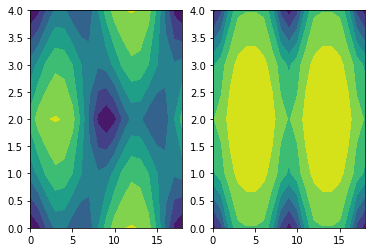

In [6]:
surface_list = ['fcc111', 'fcc100']
fig, ax_list = plt.subplots(ncols=2, nrows=1, sharex=True)

potential = 'Al_Mg_Mendelev_eam'
for i, surf in enumerate(surface_list):
    with pr.open(surf) as pr_test:
        ax= ax_list[i]
        Al = pr_test.create_surface('Al', surf, (1,2,12), vacuum=10, orthogonal=True)
        ref_job = pr_test.create_job(pr_test.job_type.Lammps, 'ref_job')
        ref_job.structure = Al
        ref_job.potential = potential
        ref_job.calc_minimize()
        gs = GammaSurface(ref_job, potential, n_mesh=(5,19))
        gs.run_gamma()
        gs._collect()
        ax.contourf(np.reshape(gs.e_lst, (gs._mesh_x,-1)))
